In [1]:
import google.generativeai as genai
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time

### Mock Product Dataset

In [2]:
data = [
    # --- Boho / Nature-inspired ---
    {"name": "Boho Dress",
     "desc": "Flowy, earthy-toned dress perfect for carefree summer festivals and outdoor gatherings.",
     "vibes": ["boho", "relaxed", "nature"]},

    {"name": "Floral Maxi Dress",
     "desc": "Bright floral maxi dress with flowing fabric for vibrant, free-spirited brunch looks.",
     "vibes": ["boho", "vibrant", "feminine"]},

    {"name": "Linen Pants",
     "desc": "Breathable beige linen pants for a casual coastal and minimalist look.",
     "vibes": ["casual", "minimal", "natural"]},

    # --- Urban / Streetwear ---
    {"name": "Denim Jacket",
     "desc": "Classic blue denim jacket with an urban edge, versatile for casual streetwear.",
     "vibes": ["urban", "street", "casual"]},

    {"name": "Leather Jacket",
     "desc": "Black leather biker jacket for a bold, confident, and edgy urban look.",
     "vibes": ["edgy", "urban", "confident"]},

    {"name": "Streetwear Sneakers",
     "desc": "Chunky sneakers with bold colors and a confident street-style statement.",
     "vibes": ["street", "bold", "confident"]},

    {"name": "Cargo Pants",
     "desc": "Utility-style cargo pants with pockets, perfect for adventurous and functional streetwear.",
     "vibes": ["functional", "street", "adventurous"]},

    {"name": "Graphic Tee",
     "desc": "Casual t-shirt with bold graphic prints that express individuality and youthful energy.",
     "vibes": ["casual", "youthful", "expressive"]},

    # --- Cozy / Warm / Comfy ---
    {"name": "Cozy Sweater",
     "desc": "Soft, oversized sweater in warm tones for relaxing, comfy winter days.",
     "vibes": ["cozy", "warm", "chill"]},

    {"name": "Wool Coat",
     "desc": "Long wool coat bringing luxury and warmth to elegant cold city nights.",
     "vibes": ["classic", "elegant", "warm"]},

    # --- Sporty / Active ---
    {"name": "Athleisure Set",
     "desc": "Comfortable, stretchy gymwear perfect for energetic, active, and sporty lifestyles.",
     "vibes": ["sporty", "energetic", "active"]},

    # --- Elegant / Formal ---
    {"name": "Silk Blouse",
     "desc": "Elegant silk blouse with a smooth finish, ideal for formal evenings or classy gatherings.",
     "vibes": ["elegant", "formal", "sophisticated"]},
]

df = pd.DataFrame(data)
df

,name,desc,vibes
0,Boho Dress,"Flowy, earthy-toned dress perfect for carefree...","[boho, relaxed, nature]"
1,Floral Maxi Dress,Bright floral maxi dress with flowing fabric f...,"[boho, vibrant, feminine]"
2,Linen Pants,Breathable beige linen pants for a casual coas...,"[casual, minimal, natural]"
3,Denim Jacket,"Classic blue denim jacket with an urban edge, ...","[urban, street, casual]"
4,Leather Jacket,"Black leather biker jacket for a bold, confide...","[edgy, urban, confident]"
5,Streetwear Sneakers,Chunky sneakers with bold colors and a confide...,"[street, bold, confident]"
6,Cargo Pants,"Utility-style cargo pants with pockets, perfec...","[functional, street, adventurous]"
7,Graphic Tee,Casual t-shirt with bold graphic prints that e...,"[casual, youthful, expressive]"
8,Cozy Sweater,"Soft, oversized sweater in warm tones for rela...","[cozy, warm, chill]"
9,Wool Coat,Long wool coat bringing luxury and warmth to e...,"[classic, elegant, warm]"


### Generate Text Embeddings

In [3]:
load_dotenv("key.env")

api_key = os.getenv("Google_API_KEY")

if api_key:
    print("API key loaded!")
else:
    print("Key not found — please check your .env file or set manually.")

genai.configure(api_key=api_key)

API key loaded!


In [4]:
def get_gemini_embedding(text, model="models/embedding-001"):
    text = text.replace("\n", " ")
    result = genai.embed_content(model=model, content=text)
    return result["embedding"]

df["embedding"] = df["desc"].apply(lambda x: get_gemini_embedding(x))
print("Generated embeddings for all products!")

Generated embeddings for all products!


### Vibe Query + Matching via Cosine Similarity

In [5]:
def vibe_matcher(query, df, top_k=3):
    query_emb = np.array(get_gemini_embedding(query)).reshape(1, -1)
    product_embs = np.vstack(df["embedding"].values)
    sims = cosine_similarity(query_emb, product_embs)[0]

    df["similarity"] = sims
    top = df.sort_values("similarity", ascending=False).head(top_k)[["name", "desc", "similarity"]]
    return top

query = "energetic urban chic"
matches = vibe_matcher(query, df)
matches

,name,desc,similarity
7,Graphic Tee,Casual t-shirt with bold graphic prints that e...,0.722214
5,Streetwear Sneakers,Chunky sneakers with bold colors and a confide...,0.712633
0,Boho Dress,"Flowy, earthy-toned dress perfect for carefree...",0.697107


### Handle Edge Cases

In [6]:
def safe_vibe_matcher(query):
    if not query.strip():
        return "Empty input — please describe your vibe!"

    top = vibe_matcher(query, df)
    if top["similarity"].max() < 0.5:
        return "No strong match found. Try a clearer vibe like 'relaxed boho summer'."
    return top

safe_vibe_matcher("luxurious classy evening")

,name,desc,similarity
9,Wool Coat,Long wool coat bringing luxury and warmth to e...,0.692521
11,Silk Blouse,"Elegant silk blouse with a smooth finish, idea...",0.684311
8,Cozy Sweater,"Soft, oversized sweater in warm tones for rela...",0.590013


### Evaluate on Multiple Queries + Latency

In [7]:
import time

queries = ["energetic urban chic", "cozy autumn", "beachy minimal style"]
results = []
for q in queries:
    start = time.time()
    top = vibe_matcher(q, df)
    latency = time.time() - start
    best_score = top["similarity"].max()
    results.append({"query": q, "best_score": best_score, "latency": latency})

eval_df = pd.DataFrame(results)
eval_df["good_match"] = eval_df["best_score"] > 0.7
eval_df

,query,best_score,latency,good_match
0,energetic urban chic,0.722214,1.536819,True
1,cozy autumn,0.735664,1.229567,True
2,beachy minimal style,0.755903,1.204685,True


### Visualizing Latency

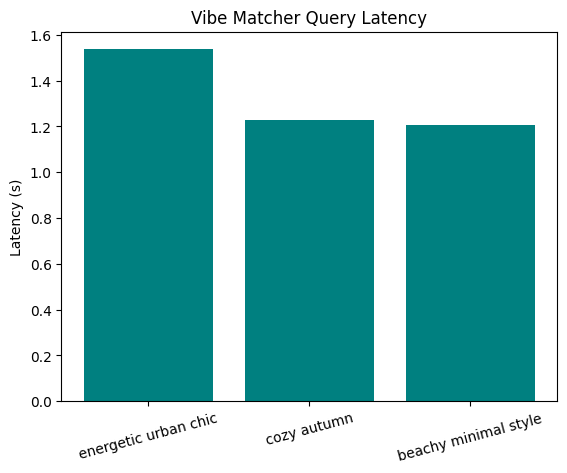

In [8]:
plt.bar(eval_df["query"], eval_df["latency"], color="teal")
plt.ylabel("Latency (s)")
plt.title("Vibe Matcher Query Latency")
plt.xticks(rotation=15)
plt.show()